### LSTMによるテキスト生成

RNNを使ってシーケンス（系列）データを生成する。<br>
ここでは「シーケンスデータを作成」することだけが取り上げられるが、<br>
「新しい音楽を作成するための音符列」や「絵画を一筆ずつ生成するための筆跡データの時系列」への応用が可能。<br>

### RNN

RNNは音楽生成、対話生成、画像生成、音声合成、分子設計に使用され、大きな成功を収めている。<br>

### シーケンスデータを生成する方法

以前のトークンに基づいて、次のトークンの予測をできるモデルは言語モデルと呼ばれる。<br>
言語モデルは、言語の統計的な構造である潜在空間を捕捉する。<br>

言語モデルの学習が完了したあとは、サンプリングを行うことが可能。<br>
「入力として最初のテキスト文字列を与え、次の文字または単語を単語の生成を要求し、<br>
生成された出力を入力データに追加する」というプロセスを何度も繰り返す。<br>
このプロセスを図解すると以下のよう。<br>

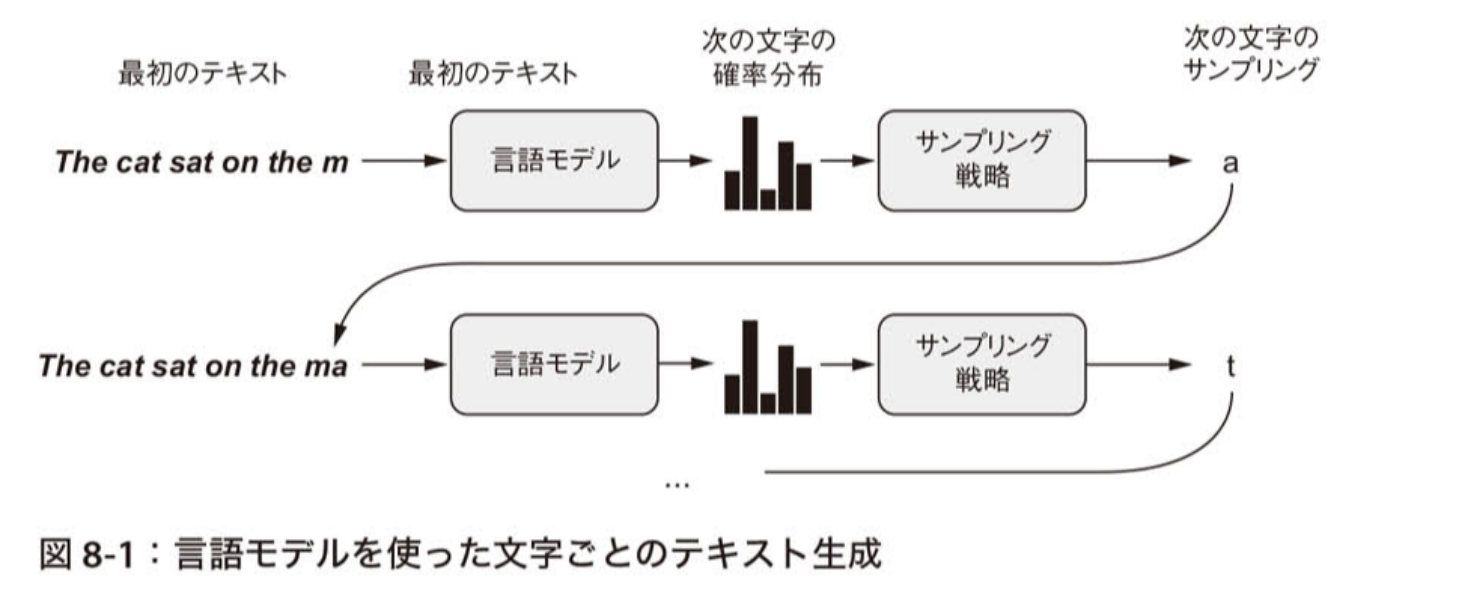

In [60]:
# 画像の表示
from IPython.display import Image
Image(filename='IMG/00.png', width=600)

最初のテキスト文字列は、コンディショニングデータと呼ばれる。<br>
ここの例では、テキストコーパスから抽出された$N$個の文字からなる文字列をLSTM層に与えることで、<br>
$N + 1$個の文字を予測させる。<br>

### サンプリング戦略の重要性

貪欲的サンプリング　: 確率分布からのサンプリングと考えることができる。<br>
特定の文字の確率は1であり、それ以外は0である。<br>
確率的サンプリング : 'e'が次の文字である確率が30%であった場合、<br>
'e'が選ばれる確率は30%ということ。<br>

確率的サンプリングの場合、<br>
エントロピーが小さいほど、生成されるシーケンスはより予測可能な構造を持つようになる。<br>
逆にエントロピーが大きいほど、意外性と独創性に富んだシーケンスが生成される。<br>

サンプリングプロセスの確率の度合いを制御するには、ソフトマックスの温度と呼ばれるパラメータを導入する。<br>
このパラメータは次の文字の選択をどれくらい意外な（または予測可能な）ものにするかを制御する。<br>

パラメータをtemperatureとしたら、確率分布を再荷重することで、<br>
元の確率分布から新しい確率分布を計算できる。<br>

In [61]:
# 異なる温度での確率分布の際荷重
import numpy as np

# original_distributionは確率値からなる1次元配列のNumpy配列
# 確率値の総和は1であること。
# temperatureは出力分布のエントロピーを定量化する係数
def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    print(distribution)
    distribution = np.exp(distribution )
    
    # 再荷重された元の確率分布を返す
    # 新しい確率分布の総和は1にならない可能性があるため、
    # 新しい分布を取得するために総和で割っている。
    # print(distribution)
    return distribution / np.sum(distribution)

In [62]:
original = np.array([1,2,3])
result = reweight_distribution(original)

[0.         1.38629436 2.19722458]


In [63]:
result

array([0.07142857, 0.28571429, 0.64285714])

温度が高ければ高いほど、より意外性の高い非構造化データが生成される。<br>
逆に、温度が低ければ低いほど、ランダム性の低いはるかに予測可能なデータが生成される。<br>

### LSTMによる文字レベルのテキスト生成

In [64]:
# 最初のテキストファイルのダウンロードと解析
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt'
)
text = open(path).read().lower() # 小文字化
print('Corpus length : ', len(text))

Corpus length :  600893


In [65]:
# 文字のシーケンスのベクトル化
maxlen = 60
step = 3
sentences = list()
next_chars = list()

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i:i+maxlen])
    next_chars.append(text[i + maxlen])
    
print('Number of sentences:', len(sentences))

# コーパスの一意な文字のリスト
chars = sorted(list(set(text)))
print('Unique characters : ', len(chars))

# これらの文字を文字をリストcharsのインデックスにマッピングするディクショナリ
char_indices = dict((char, chars.index(char)) for char in chars)

print('Vectorization ... ')

# one-hotエンコーディングを適用して文字を２値の配列に格納
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('Done')

Number of sentences: 200278
Unique characters :  57
Vectorization ... 
Done


### ネットワークの構築

このネットワークは、単一のLSTM層、それに続くDense層、そして全ての候補文字列に対するソフトマックス関数で構成されている。<br>

In [66]:
# 次の文字を予測する単層LSTM
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape = (maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

In [67]:
# モデルのコンパイル設定
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

### 言語モデルの訓練とサンプリング

学習済みのモデルとテキストシードが揃ったあとは、以下の作業を繰り返すことで、新しいテキストを生成できる。<br>

<ol>
    <li>それまでに生成されたテキストをもとに、モデルから次の文字の確率分布を抽出。</li>
    <li>この確率分布を特定の温度で再荷重する。</li>
    <li>再荷重された確率分布にしたがって、次の文字をサンプリングする。</li>
    <li>それまでに生成されたテキストの最後に新しい文字を追加</li>
</ol>

In [68]:
# モデルの予測に基づいて次の文字をサンプリングする関数
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [71]:
#　テキスト生成ループ
import random
import sys

# モデルを60エポックで訓練
for epoch in range(1, 60):
    print('epoch', epoch)
    
    # 1エポックでデータを学習
    model.fit(x, y, batch_size=128, epochs=1)
    
    # テキストシードをランダムに選択
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index : start_index + maxlen]
    print('--- Generating with seed : "' + generated_text +'"')
    
    # ある範囲内の異なるサンプリング温度を試してみる
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('--------- temperature: ', temperature)
        sys.stdout.write(generated_text)
        
        # 400文字を生成
        for i in range(400):
            
            # これまでに生成された文字にone-hotエンコーディングを適用
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
            
            # 次の文字をサンプリング
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            
            generated_text += next_char
            generated_text = generated_text[1:]
            
            sys.stdout.write(next_char)
            sys.stdout.flush()

epoch 1
Epoch 1/1
200278/200278 [==============================] - 186s 926us/step - loss: 1.6614
--- Generating with seed : "e to see that intercalary
days are appointed, on which such "
--------- temperature:  0.2
e to see that intercalary
days are appointed, on which such a soul and soul and and into the subjection of the sure the conscience of the concerning to conscience and and the spirit of the spirit of and the spirit of the same the spirit and and soul and the propecies to the spirit and moral and the conscience of the spirit and the spirit of the surden the spirit to the same the spirit the propection of the sacrifice and in the spirit of the conscience of t--------- temperature:  0.5
on of the sacrifice and in the spirit of the conscience of their say, and interpord and the promad one with the had to disclose, and dispation of our does the distructions our seems of the sacrion of and waster to pard from a cover whom because of the fortherd the
propecty only only present of t

chrrypatement, covited patic. else thou'st
biving "high" intisa
nays recent of -oneself!
there is imabrate ro without ca
notharour." highes
attain to new three. all ghe tests. we comil and righerful--presidernes and
men  by the :


, ills as in
these cly. but those now the srary
of himself need of thommen of equal with a latery (i

/Users/Takanori/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


dea just
biffing in raliem nemb, atralmicniturs epoch 5
Epoch 1/1
200278/200278 [==============================] - 184s 918us/step - loss: 1.5010
--- Generating with seed : "the mysteries of demeter and dionysos and in the
christian e"
--------- temperature:  0.2
the mysteries of demeter and dionysos and in the
christian extrestation of the still the states that the same the states that the states the sense to the states to the states the states to the spirit, and all the states to the states to the still the states to the states and the spirit of the states that the suffering the states and a thing of the states and the states to the states to the states to father of the states to the still and the still the still--------- temperature:  0.5
to father of the states to the still and the still the still themselves the states, and man, for the impulse of the said, that the the fore. the matter that the states as the things. there is an man that the sware still--the hard of the moral him o

 atot o at ta t i t at l tre t t te ot tepoti atio ti at e teot tite ti  itsel o to e t at
thatetii teteo a tiseo atitat time titeot ti  tateto ataat i  tit e tte  i t tid o at tath aat" at tit ou tat a at a ad th at th t w(thin ti ot at a ti o astou ti tid attin atatatatot aliope t o to ai o  oti o it tis titei o atatata t ata atatatatet e tait at ot tite ate atat ate ti  t tit t o t t atatatat th  atti at tis titeo aie atatot to e to at ot ti  t t t o  tepoch 9
Epoch 1/1
200278/200278 [==============================] - 183s 914us/step - loss: 7.2536
--- Generating with seed : "e scale, that greek and indian
literature has nothing to com"
--------- temperature:  0.2
e scale, that greek and indian
literature has nothing to comenore tho e atoe andit otie at e atmet tie as e a  at ot patoe at atimele tare at at to at at atio toe as of an te ait ta ce a  tatie ood te te at it at at e at at he asoe t it atoe oode a atie tat itit toe d le potsa- an tat to to thi watit at ev te at oe it it o

o a eate a at ot a a to a a to to to a a to it a a at to to teee ot it ot it it   to ot it tiet eit eatitiote a a tatiet ot it ot it ee toe ot at a a a at a a ot it ot a tee aat it it it it a a to it a taat atie a to teettee it it toate ot a attiot ot ot ot eeatiotioteeteit it ot it it eate at to ot a a a at eate it ete a atate to it it ot to it i  a ot eitae ao a it eate     to a a tee a to at eat tiotiote eeatiotiete ot ate to to a eate to a to a to it t--------- temperature:  1.2
t tiotiote eeatiotiete ot ate to to a eate to a to a to it to toot tate a a to it eotateeate etait teet e ot at a ot ot it eitatiot to it it a ot a to to it ot a it  o ot it ot to it ot to tatte a tiete ee a to to to to a tettiot a it e ot a ot eatiotie a a to ot ao a it it a ot to it ot ot eatia a to to it      to toete a atate ot e ot to io tiottato tee it it it eato a to to a eate to to tait a tee ot ot a a tate a it ee tootte to  a aatea a toit att a aepoch 13
Epoch 1/1
200278/200278 [==================

 t t t t t                                                                                                                                                                                                                                                                                                                                                                                                                                a t t t t t t t t t t a t t t t t --------- temperature:  1.0
                          a t t t t t t t t t t a t t t t t t t t t t t t t t t a taiitiot ioit t t t t t t a t t t a t a tatt tatit to iatiot a tate tait atto a taatiatit o ot a tate it tait a to oatie ot a to ete a teit oto it toat titatit tiotiate       taate it it ia tate ot it it to att ot to a att to to t t t tait to t t a t t tatt tiet a tit i                  tattatiatiitaitiot a to ato ta tatt ot to a tate tatiatt a to a ie eat at a taatiot a tait--------- temperature:  1.2
 tatt ot to a tate tatia

the use of her proper weapons; to let-herse a to to at tatiot a to to to a to to at to a to to tatiot to to tatiot to to tatiot to to to at to to at to a to to at to a tatiot to to to to tait to to tatiot to to at to a to to to to tait a to to to to to to to tait to to tatiot to to to to at to a to to ot to to to tait to to a to to to to a to to at to to at to a to to to tatiot to to tatiot to to ot to to tait to to tate a to to tatiot to --------- temperature:  0.5
 to tatiot to to ot to to tait to to tate a to to tatiot to to tatatiot to tait at a totit to to at ot tait ot it to it to to to it tatiot a to a tait to to to it to to tatiot to to a at tit a to at tattait a tatiot to a it to toat to a to a to to at to tate a o to to tatiatiot to to to ot tate to a a to to at to at to a it to to to tatiot to tiot to taite o a it tatait at oo to o a to ea tot to taite a to to et to to too to  to to tatiot to to at tatait t--------- temperature:  1.0
aite a to to et to to too to  to to tatio

o  t to ite o  eaat i o at a to a to to o at eat a to to o it o o a ot o  te  a t ot at i o o  to e to o o e o eao o oo itiate a o oo o o o e to eate a tait e t at ao a o   to to   t at o i a it it e teat it at et ot i o oto ait a too o tiottoite otiite ot a tote to toot it toot io aot it ete itotiot itataat to o    tea oo ait a a tieee toet o o at eaie o o to o at to taitatate ot aa eate o i ot iate o eot a to aa  tea to o a t ot ato i o ea  te to ote eaiepoch 24
Epoch 1/1
200278/200278 [==============================] - 182s 911us/step - loss: 8.6845
--- Generating with seed : "is far too easily frightened; his conscience is schooled so
"
--------- temperature:  0.2
is far too easily frightened; his conscience is schooled so
to a to it it it to it it ihe it it i  a to o o it it it i eatio to it a to to it it it it i eatio a to o it a to o it it it it i o it it i eatio to it it it i  it a to a to it it a to it a to o it it i eatio i o it a to it it it it it i o it it it it it it it it

e a to a to a ot it it a taie it to to to a ot to it a tait to to to a to a taitat o ot ot it eite to a taote a to to ate a o a taitio tiot oto it i e etaiae at o ot a too it ot o etee eteit a too otaatiot eto a eat o  a to i ot a to o eto atio taite i oto ot toatto i aa ot ato a tiotiot a etiot a to o etait ot toet a atiot it ot a tatiot it ot at eatiot o e a to a it it at it i etiot it iteat ot to toat o   to eate o etiot to i ot at o ea eto o ato ot a o--------- temperature:  1.2
to toat o   to eate o etiot to i ot at o ea eto o ato ot a otioe to i ot a tatiot o etee ot at iteete o a teotaate o ete o o o ot o ea  aa at a ite ot ait at a etiot it a o too ot a o atiteote eatoot a ottie ot at it etee a tatte a io eatiot a it a toe attiot a tatie oto to etioe it it it o it it e toe itoota etoote otitiot o eat it a taatitiot at ot a teatio ate a ea to a tiee it ot at ot toieatiot i  at it to eatie oto it ea tat att tee o ite ot a oto teepoch 28
Epoch 1/1
200278/200278 [==================

t it it atiot it it it it it it ot ot ot ot ot a ot at to ot o otiot at o it atiot ot it atiot o o it to it it it a       o to it ot ot it ot it io ate ot it it it it atiot a to to to o it to to to it a ot at a ot it it it it to it it ot ot a ot o  to ot ot a to to ot it it it ot o o eitiot o to to it it attiot it ot ot ot it it ot a  t a to it it to ot atiot o to to to to to at o eatiot it atiot o it to tiatiot it it it ot ot o eatiotiot it it atiot ot e --------- temperature:  1.0
o it to tiatiot it it it ot ot o eatiotiot it it atiot ot e at too otiot ot a it i ot ot o it ot otiot ot to ate ot o o o it ot ot atiot eate ot o it ot ot ot ee it ot o it tiitiotto i   to a eo a ite it ot ot ot o atiot at it it it it to it o o it atioe attoe o o  e to tit a ot a it taio it io it to it it atiot otioe ot it it eat it it it to to it it o ea otio iiatiot to o it it it o e it it to attiotiot o atiot ot o o eat ot ot o eatiot a o  to to to it --------- temperature:  1.2
ttiotiot o atiot ot o o 

and eliminate them. an instant alleviation and narcotio o to to to a ot a to to to to to to to a ot to to to to to to ot ot ot a otiotio a to to it at ot a it it it it it it  e e t o    toit oe to to it it       to eatio it ot ot ot a ot a ot it at ot it it  te a ot a ot it ot iitio       e it atiet ot e to it atio to t oe ee taite ot ot ot ot a ot a ot a ote a ot a to tee a o aitio otio   i iitie ot ot ot it at ot a it it it it it it etea to toie a --------- temperature:  0.5
 iitie ot ot ot it at ot a it it it it it it etea to toie a tite ot it at ot it it0io ee it a ot a ot ot eatio e ot at oetiot a o it ot ot it at a ot it it  tio   e to a ot ot it it it it it e to a to a ie it it it eatie ot o  it ot a it it it it it it it it  te ate t it it it it it it it  e to titae ot iit ete to taite ot a ot oe eatie it it i ot ot at ea to ot ot it a otie it       i it it it itte to ie it at a ote it it it it  ta to it at a it it it it --------- temperature:  1.0
te to ie it at a ote it it it 

ettaooitiae ot ot titaie tat it a it  a atittioiateo  a etatteitt attiot atatitioto tiatit ate e aoit ate e a titatitt ttetote to teit tiot at titaa a tote ta a ate  otittie ot t to t at a to tiatiato ttoteit iotat aet attit teot tie e at aitiotitt atat tete tititittaititt atit titto teteotatiott ot itit att a atiet atitioe oottiat att at a tittaititt ot tiateiotititee e ot tetiet tattatet a taiatoitiataiatiee ateee totat itiitote tetit ot i tee  a atie itepoch 39
Epoch 1/1
200278/200278 [==============================] - 184s 917us/step - loss: 8.6705
--- Generating with seed : "even more terrifying than other peoples are to themselves:--"
--------- temperature:  0.2
even more terrifying than other peoples are to themselves:--to t at a to to to te to to to to to to to t  tote to to at e to to to to at t a te to to to te to t ie to to to e a e a a te t at at ate to to to to t a te t te to to te to to to to to t ite a e a to t it t a to a at o te t a te t  a a a it t it to to to te t it

 e e to et ee t j t  a tio  he a to to eott e tte tt tttt itttto t ae a to t  ittiiet i aw toaa i e  iot ao to  io th toi o i ai oa aiiti t ie it ae tiee iiteie o eette athotoo a eie  ttait  oo ei ifeea ti eif aiie e (ieio i ett toi t  te it  aiote hi  i tto io to t ee teeiaiea oii t t ei t ie te ta rti toie ieoi a o e a ae i  ite oo o t iet ait oo t ie ?(to o tuete ao iot ai o ae tte i tt  i ii eiot  oe  iooto   o tttteee h' qi ee aitt e t tiit( tt te at --------- temperature:  1.2
iot  oe  iooto   o tttteee h' qi ee aitt e t tiit( tt te at att oitoiti t tet et to  (i?ii t aa otio a(o ti a  aao taiotat at a totot  oatheo  it t oeiiot iiiooioith tio hitio e tote e oaen  iae  t ia oki to titea  tia iee o e to t eeie ititito te ai t atitio  t  ooto a ii o oto tiiee g h tt tatfaat aaie ftee  o  atte a t ttiiattet o!titet imat e   aeeie e ta titet   it fi ote iit eoiootit  atio hio  tita t o a tnii i o  htto: ee ti  iteee to o itt eo tet epoch 43
Epoch 1/1
200278/200278 [==================

 s o asno tia n a oitie i io  otioe n tio ieot soi  ti ae ie nooo  iieaa o tt  t i  oo t  ita  i   ai titi oo a ooa se t eioo se e  ee tni siitnite  eo  ti aie oieain t otot atootetos o o aot aane  tae iitot e ne seoit tfitio oae no  o itiot  io iaa o t ii iet tee ats  tietioitea it  a tt  ooo e ti ioieatite t teee titit ateinant  s to o aita iot tatt ntae  aiit tse iiiiet te  eo ittso t iette nes a tie  it ooo te titonee aeooo t ae to toiteiaiqt neii a no--------- temperature:  1.0
 a tie  it ooo te titonee aeooo t ae to toiteiaiqt neii a noieto t  tioti  ooea oeea tois t o  tootia ntieeeeooeitanttie ato ite e toi  ne oain aieetan  aitieooel aeisq  o loo  itt e o toianito aoaiis o atts aotago o toaza ite aetiito tiot oaetaani iile tae tetio ete tii aioiseai e n seti oaoaen lioo iat ea oo o a neot e t i ettt ieatilazo t tiaieiiin et te o tiaio tioa naotieo  ataneisei ii tiie  oooi te a  t it  aiil eosa ieotae te oo atiaoe o i s itijt --------- temperature:  1.2
 oooi te a  t it  aiil e

will not only be demanded from themselves b leht  t s t t  o t anat   t   tit las tl t  nl  tees    let t atlthen lls  t se  e s  is s te  sin t l ti s to tis tohelss t t n to tne t s tn ten n ot s i tn an in  as on t  l ton  t t to s   as the t t t s t es an thetn t tist s t tte tl  ts tt  n to t  ti ti as n tno  l t  t a  t   s t alns n t s tton t e n le s   tl t l t nslll ajle taes  aint t  nntth t  a  sonnt on ts s ll n to tllennl tale--------- temperature:  0.5
taes  aint t  nntth t  a  sonnt on ts s ll n to tllennl tale t   tsnnt tas ts t tseessoet n te ta te n il t te the tlnletlit seinate  l tn t lllt o a tn s te n e  i atleaes  oninn tens tet tls t  t e nitt  a titt tle t tth oon   te  ts  nit   an sli an  t t t ts  tnl tt ll te t t  s t t anlt t s    oa nenit s te e tetle to   t inoan ns t tne   tas  ane to  to ne it ases sa nt il'in o e e tiss tht n e atnao  t t nl     se tant t ti tnl t  tasn tin    te t t--------- temperature:  1.0
n e atnao  t t nl     se tant t ti tnl t 

la eeo lneiaan lt eeaenio is eanits soaloest ahttoatl to al atins an aneeaehlat  eie  aem aaltin olleleal tse slnsotnine ile nei nenaetna ts anlae atee tane tnanoo e tesetanese tin alssteisttt en osoanste iheiess tiatts   oaoa a ool ttaln aie atta eooea o  isiannn atis snn ettoin att ta eaaslasate  tn aon teoeilit t e ee te iseeooaelosl a ilit  tneee inett t so loit esoaeneoosl t ieto ntso ienitsjeialinaensesssano noensatli tesaoaaataao  tltn tsilgse l l sepoch 54
Epoch 1/1
200278/200278 [==============================] - 195s 974us/step - loss: 6.8716
--- Generating with seed : "who is running in the race and not to him who has arrived at"
--------- temperature:  0.2
who is running in the race and not to him who has arrived at tio i in i in is  in  in an  ion   e  t   e ati s is   onii  in inl  in i tils s ii ino  i tii o  in is   in is o  ios  in o  o t iii t  i io   ii   ai io o t  on t  te  ioe t t  in  on   io  i  oo t i o in isn t  ti  i  ino i io is t  ion en in iti  oio is  s  

 t ia tine  noansleio tsion n ontio n  ono anin as an t a  anta o e oonts is i n ntseanotanes  t oe ais atsan nei it eaa enitot alo ettesini a e so aos nnaa inoee e e itie iasos  tsolaneonn   oee ollinin inrnnilet eenaisiaie  to ale n e niisitsa a ies as is les enin teel ie e isnnaoontsae tsstenisine f testins t itten tsiitloneisesseenn n oetinn seiniiteto  aneniaanis in nininesssona s e nitlinaoi as ne onstaiine tose titi onsn tneiansitilnon eiietionten i--------- temperature:  1.2
 as ne onstaiine tose titi onsn tneiansitilnon eiietionten isso nose isoiso itonei   ro one se ieeiininse ilast te t titosseaens an ntin isieisinesisi o oa  nieilnsls ense neill anat ana l tsesoatoe oastn eeno innto atne  e t  n not aetonesse  sinsiansoong aas toonenesno ts t tna sle le as ten  arlitoaniesenn  n iaoins iio ti tn on ninoistia oeao nttoesies atonrr oeiantonoetliinon itione setins n tsliontitislesle lintinn e a ntenial  sentloa tiinoneeia tssepoch 58
Epoch 1/1
200278/200278 [==================

### まとめ

<ul>
    <li>以前のトークンから次の（１つ以上のトークン）を予測するモデルを訓練することで、離散的なシーケンスデータを生成可能。</li>
    <li>テキストの場合、言語モデルと呼ばれる。</li>
    <li>次のトークンをサンプリングするには、モデルが学習した内容とランダム性の導入との間でバランスをとる必要性がある。</li>
    <li>正しい温度を割り出すために、常にさまざなな温度を用いて実験する。</li>
</ul>